<p style="font-size:32px; font-weight: bolder; text-align: center"> Molecular dynamics and sampling </p>

This notebook provides a hands-on counterpart to the "Molecular dynamics and sampling" lecture for the MOOC "Path Integrals in Atomistic Modeling". If you haven't done so already, check the [getting started](0-getting_started.ipynb) notebook to make sure that the software infrastructure is up and running. 

The different sections in this notebook match the parts this lecture is divided into:

1. [Thermodynamics and phase-space sampling](#thermo-and-sampling)
2. [Molecular dynamics and integrators](#integrators)
3. [Efficiency of sampling](#sampling-efficiency)
4. [Langevin dynamics](#langevin)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
import chemiscope
import pimdmooc
pimdmooc.add_ipi_paths()

<a id="thermo-and-sampling"> </a>

# Thermodynamics and phase-space sampling

We consider a (classical) harmonic oscillator with frequency $\omega$ and unit mass, in the constant-temperature ensemble at inverse temperature $\beta$

In [2]:
def pot_sho(q, omega=1):
    """ The potential for a simple harmonic oscillator with frequency omega and unit mass"""
    return omega**2*q**2/2
def kin_sho(p):
    """ The kinetic energy for a particle with unit mass"""
    return p**2/2
def ham_sho(p, q, omega=1):
    """ The Hamiltonian for the simple harmonic oscillator """
    return kin_sho(p) + pot_sho(q, omega)

In [3]:
# defaults: beta=1; omega0=2
beta = 1
omega0 = 2

## Integration on a grid

First, we compute the partition function and observables using explicit integration on a grid - using the simplest rectangle integration

In [4]:
# defaults: ngrid=16
ngrid = 16

pgrid = np.linspace(-10,10,ngrid)
dp = pgrid[1]-pgrid[0]

qgrid = np.linspace(-10,10,ngrid)
dq = qgrid[1]-qgrid[0]

pqgrid = np.meshgrid(pgrid, qgrid)

In [5]:
ham_grid = ham_sho(pqgrid[0], pqgrid[1], omega=omega0)

In [6]:
Z = np.exp(-ham_grid*beta).sum()*dp*dq
print("Partition function: ", Z)

Partition function:  2.7501746743123636


note that the partition function (and the probability) can be factorized

In [7]:
pot_grid = pot_sho(qgrid, omega=omega0)
kin_grid = kin_sho(pgrid)
Zp = np.exp(-kin_grid*beta).sum()*dp
Zq = np.exp(-pot_grid*beta).sum()*dq
Z - Zp*Zq

-8.881784197001252e-16

The mean potential and kinetic energy can be computed as a weighted mean, and again one can equally well compute it on just the relevant variables

In [8]:
pot_mean = (pot_sho(pqgrid[1], omega=omega0)* np.exp(-ham_grid*beta)).sum()*dp*dq/Z
print("Average potential: ", pot_mean)

kin_mean = (kin_sho(pqgrid[0])* np.exp(-ham_grid*beta)).sum()*dp*dq/Z
print("Average kinetic:   ", kin_mean)

Average potential:  0.8946867496531024
Average kinetic:    0.5003344962671552


In [9]:
pot_mean_q = (pot_grid*np.exp(-pot_sho(qgrid, omega=omega0)*beta)).sum()*dq/Zq
pot_mean - pot_mean_q

0.0

In [10]:
kin_mean_p = (kin_grid*np.exp(-kin_sho(pgrid)*beta)).sum()*dp/Zp
kin_mean - kin_mean_p

1.1102230246251565e-16

<p style="color:blue; font-weight:bold"> What is the expected value of $Z$, $\langle V \rangle$, $\langle K \rangle$? Experiment with different `ngrid` parameters. How many grid points you need to converge the values to roughly 1%. </p>

## Stochastic integration

Naively, we can generate uniform random samples over a large interval, and compute the average by Monte Carlo integration

In [11]:
# defaults: nmc=1000
nmc = 1000

In [12]:
qmc = np.random.uniform(-10,10,size=(nmc))

In [13]:
pot_mc = pot_sho(qmc, omega=omega0)
prob_mc = np.exp(-pot_mc * beta)
pot_mean = (prob_mc*pot_mc).mean() / prob_mc.mean()
print("Average potential: ", pot_mean)

Average potential:  0.48590423327777726


Most of the samples are "wasted" over low-probability regions

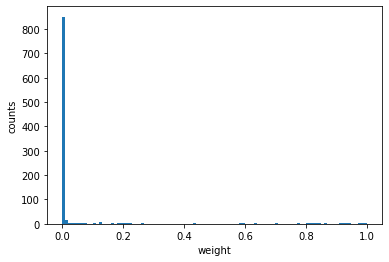

In [14]:
plt.hist(prob_mc, bins=100)
plt.xlabel("weight"); plt.ylabel("counts");

<p style="color:blue; font-weight:bold">Repeat the calculation with different numbers of random samples, to get a feeling for the statistical uncertainty and the convergence behavior. What would happen if you reduced the range of the grid to a narrower region around $0$?</p>

You could also rather easily wrap the generation and evaluation in a function to compute more quantitatively the uncertainty over multiple executions.

## Importance sampling

To avoid wasting samples on low-probability regions, we can generate a sequence of configurations that are distributed according to the target probability. 
This uses a Metropolis Monte Carlo scheme, which is not explained in the course. The [original publication](http://doi.org//10.1063/1.1699114) is a classic, and very accessible.

In short, the algorithm works by first _proposing_ a change to the configuration, in a way that is symmetric $u(q_0 \rightarrow q_1) = u(q_1\rightarrow q_0)$. Here we take a random step between $-\Delta q$ and $\Delta q$. 

The probabilities in the initial and final state are then compared, and an _acceptance_ criterion is applied to actually update the position, or to keep the system in $q_0$. The overall probability of making a move is the product of the proposal and acceptance probabilities, $p(q_0\rightarrow q_1) = u(q_0\rightarrow q_1) a(q_0\rightarrow q_1)$.
The criterion is designed so satisfy the detailed-balance condition $P(q_0) p(q_0\rightarrow q_1) = P(q_1) p(q_1\rightarrow q_0)$.

In [15]:
def metropolis_step(q0, step=1):
    """"Performs one step in a Monte Carlo procedure, following the Metropolis scheme, cf.
    N. Metropolis, A. W. Rosenbluth, M. N. Rosenbluth, A. H. Teller, and E. Teller, 
    "Equation of State Calculations by Fast Computing Machines," 
    Journal of Chemical Physics 21(6), 1087–1092 (1953).
    """
    
    # NB: this implementation recomputes the potential at each step, which is 
    # very wasteful - potential could be stored and reused between steps
    pot0 = pot_sho(q0, omega=omega0)
    
    # generates a random displacement (with symmetric probability)
    q1 = q0 + np.random.uniform(-1,1)*step
        
    pot1 = pot_sho(q1, omega=omega0)
    
    # computes the ratio of initial and final probabilities        
    pratio = np.exp((pot0-pot1)*beta)
    
    # accepts or rejects the move to enforce a detailed balance condition
    if (pratio > np.random.uniform(0,1)):
        return q1
    else:
        return q0

In [16]:
# defaults: q=0, nstep=1000, mcstep=1
q = 0
nstep = 1000
mcstep = 1

traj_q = np.zeros(nstep)
for i in range(nstep):    
    q = metropolis_step(q, step=mcstep)
    traj_q[i] = q

The position fluctuates around equilibrium, and is distributed according to $P(q)$. Note that strictly speaking one should discard the first few steps as they are needed to reach equilibrium.   

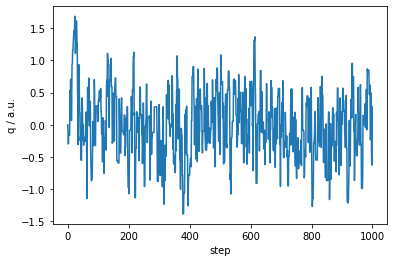

In [17]:
plt.plot(traj_q)
plt.xlabel("step"); plt.ylabel("q / a.u.");

Text(0, 0.5, 'counts')

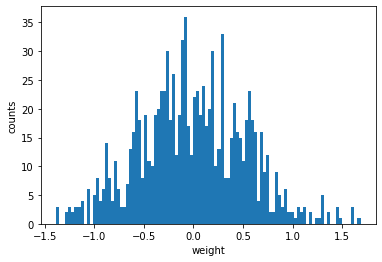

In [18]:
plt.hist(traj_q[10:], bins=100)
plt.xlabel("weight")
plt.ylabel("counts")

In [19]:
pot_mean = pot_sho(traj_q, omega = omega0).mean()
print("Average potential: ", pot_mean)

Average potential:  0.5687402333731063


<p style="color:blue; font-weight:bold">
Change the magnitude of the step (variable `mcstep`) to 0.01 and to 100. 
What consideration can you make on the efficiency of the probability sampling process?
</p>

This topic will be investigated further in [section 3](#sampling-efficiency)

<a id="integrators"></a>

# Molecular dynamics and integrators

This section requires use of i-PI, so make sure you have it installed and have familiarized yourself with how to run it in the [getting started](0-getting_started.ipynb) section. 

Here we will modify an existing i-PI input to run constant-energy simulations for a small simulation of liquid water, based on the q-TIP4P/f forcefield ([original paper](http://doi.org/10.1063/1.3167790)), run short trajectories and inspect the output.  

We will first go to the appropriate folder, create a copy of the template and edit it.  You will need to open a terminal and execute

```
$ cd pimd-mooc/1-getting_started
$ cp template_integrator.xml input.xml
```

Edit the `input.xml` file. You can use `vi` in the terminal, or open the file with the file editing interface of Jupyter/Jupyterlab. 

First, we are going to set up a rather "by the book" simulation - a conservative time step for liquid water is of the order of 0.5 fs. Look for the time step specification and edit it so it reads `<timestep units='femtosecond'> 0.5  </timestep>`. You should also set the output prefix to a memorable name - it is recommended to use `<output prefix='md-ts_0.5'>` to be compatible with the postprocessing in this notebook.

Then launch i-PI and the driver - either using two terminals or putting i-PI in the background.

```
$ i-pi input.xml &> log &
$ i-pi-driver -u -h driver -m qtip4pf 
```

we can load the output and plot it. One sees how potential and kinetic energy fluctuate wildly (over an energy scale of a significant fraction of a Hartree, while 

In [23]:
ts_05 = pimdmooc.read_ipi_output('1-md_sampling/md-ts_0.5.out')

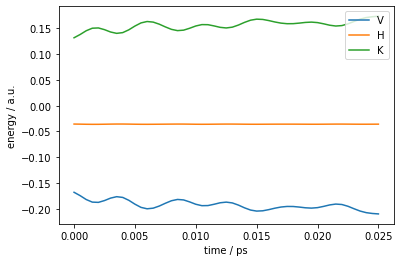

In [25]:
plt.plot(ts_05["time"], ts_05["potential"], label="V")
plt.plot(ts_05["time"], ts_05["conserved"], label="H")
plt.plot(ts_05["time"], ts_05["kinetic_md"], label="K")
plt.xlabel("time / ps"); plt.ylabel("energy / a.u."); 
plt.legend()

Now modify `input.xml` to run a simulation with timestep of 1.0 fs, 1.5 fs and 2.0 fs, running each time a separate simulation; make sure to also change the output `prefix` accordingly - use e.g. `'md-ts_2.0'` as format, or adjust the plotting cells below to reflect your naming scheme. 

_NB: wait for each calculation to be finished before launching another one - otherwise, you will have to give different names to each of the socket files_

After running the simulations, we can inspect the behavior of the conserved quantity to check for the accuracy of integration

In [ ]:
ts_10 = pimdmooc.read_ipi_output('1-md_sampling/md-ts_1.0.out')
ts_15 = pimdmooc.read_ipi_output('1-md_sampling/md-ts_1.5.out')
ts_20 = pimdmooc.read_ipi_output('1-md_sampling/md-ts_2.0.out')

In [ ]:
plt.plot(ts_20["time"], ts_20["conserved"], label=r"$\Delta t = 2.0$ fs")
plt.plot(ts_15["time"], ts_15["conserved"], label=r"$\Delta t = 1.5$ fs")
plt.plot(ts_10["time"], ts_10["conserved"], label=r"$\Delta t = 1.0$ fs")
plt.plot(ts_05["time"], ts_05["conserved"], label=r"$\Delta t = 0.5$ fs")
plt.xlabel("time / ps"); plt.ylabel("energy / a.u."); 
plt.ylim(-0.04,-0.02)
plt.legend()

<p style="color:blue; font-weight:bold">
Note the sharp change in behavior of the conserved quantity. Plot also separately the potential and the kinetic energy. Is the dependence of the curves on $\Delta t$ equally telling?
</p>

You can also spot the most dramatic problems by plotting the trajectories. Many MD problems manifest themselves in quite dramatic ways when looking at the motion of the atoms!

In [ ]:
trajectory_05 = pimdmooc.read_ipi_xyz("1-md_sampling/md-ts_0.5.pos_0.xyz")

In [ ]:
chemiscope.show(frames = trajectory_05, properties = dict(
   time = ts_05["time"][::10],
   potential = ts_05["potential"][::10],
   conserved = ts_05["conserved"][::10]
))

_NB: molecules appear to be spread all over the place because they can move outside of the periodic boundaries (show the unit cell by selecting the appropriate option in the visualization menu)_

In [ ]:
# try to fold the atoms back into the supercell, and replot above
for f in trajectory_05:
    f.wrap(pbc=[1,1,1])    

for the large timestep frames, the positions quickly go into NaN territory. you might be able to see the first stages of the explosion in the last valid frame in the trajectory

In [ ]:
trajectory_20 = pimdmooc.read_ipi_xyz("1-md_sampling/md-ts_2.0.pos_0.xyz")
n_ok = 0
for f in trajectory_20:
    if not np.isnan(f.positions.sum()):
        n_ok+=1

In [ ]:
chemiscope.show(frames = trajectory_20[:n_ok], properties = dict(
   time = ts_20["time"][::10][:n_ok],
   potential = ts_20["potential"][::10][:n_ok],
   conserved = ts_20["conserved"][::10][:n_ok]
))

<p style="color:blue; font-weight:bold">
What would be an optimal time step for your simulation? What considerations would you make?
</p>

<a id="sampling-efficiency"></a>

# Efficiency of sampling

We now consider more quantitatively the convergence of averages with Monte Carlo sampling. You need the definitions in [section 1](#thermo-and-sampling) so if you haven't executed that section yet, go back and run through the cells once.

In [ ]:
def mc_traj(nstep, mcstep, q0=0):
    q=q0
    traj_q = np.zeros(nstep)
    for i in range(nstep):    
        q = metropolis_step(q, step=mcstep)
        traj_q[i] = q
    return traj_q

We compute the accuracy of sampling for $\langle V \rangle$, for which we know that the exact value has to be $1/2\beta$.
We repeat many times independent trajectories of the same length, and store the average potential along each trajectory.

In [ ]:
# defaults: ntraj=100; nsteps=10000; mcstep=0.05
ntraj = 100
nsteps = 10000
mcstep = 10

In [ ]:
vmean = np.zeros(ntraj)
for i in range(ntraj):
    traj_q = mc_traj(nsteps, mcstep, q0=0)
    vmean[i] =  pot_sho(traj_q, omega=omega0).mean()

The error _of one trajectory_ can be computed as the standard deviation of the means. 

In [ ]:
print("Best estimate: <V>=%8.4f ± %8.4f" % (vmean.mean(), vmean.std()) )

... this is much larger than if we used the textbook formula for the standard error in the mean of a trajectory with `nsteps` samples

In [ ]:
# defaults: nsteps=100000; mcstep=0.05
nsteps = 100000
mcstep = 0.05
traj_v = pot_sho(mc_traj(nsteps, mcstep, q0=0), omega=omega0)
print("Naive estimate:  <V>=%8.4f ± %8.4f" % (traj_v.mean(), traj_v.std()/np.sqrt(nsteps)) )

Now we compute the autocorrelation function and use it to get a better estimate of the error on a single trajectory

In [ ]:
def autocorrelate(x, xbar=None):
    """ Computes the autocorrelation function of a trajectory. 
    It can be given the exact average as a parameter"""
    if xbar is None:
        xbar = x.mean()
    acf = np.correlate(x - xbar, x-xbar, mode='same')/((x-xbar)**2).sum()
    return acf[len(x)//2:]

we use the known analytical model of $\langle V \rangle$

In [ ]:
c_vv = autocorrelate(traj_v, 0.5)

In [ ]:
plt.plot(c_vv)
plt.ylim(-0.1,1.1);
plt.xlabel(r"$\Delta$ steps"); plt.ylabel(r"$c_{VV}$")

Compute the autocorrelation time and use it to correct the standard error in the mean to account for the correlation between samples

In [ ]:
tau_v = 2*c_vv[:nsteps//10].sum()

In [ ]:
print("Autocorrelation time: %8.4f steps " %(tau_v))
print("From autocorrelation estimate:  <V>=%8.4f ± %8.4f" % (traj_v.mean(), traj_v.std()/np.sqrt(nsteps/tau_v)) )

<p style="color:blue; font-weight:bold">
Repeat calculations for different values of `mcstep` between 0.01 and 1000. Keep note of the error and make a plot of $\epsilon_V(\Delta q)$.
</p>

In [ ]:
MC = [0.01, 0.1, 1, 10, 100, 1000]
EV = [  ]  # enter the values you obtain here 
plt.loglog(MC, EV)
plt.xlabel(r"$\Delta q$ / a.u."); plt.ylabel(r"$\epsilon_V$ / a.u.")

_NB: particularly when trajectories are not super-converged, using the mean from the trajectory to estimate the offset in computing $c_{VV}$ leads to a gross underestimation of the autocorrelation time and the error_

In [ ]:
c_vv_trajmean = autocorrelate(traj_v, None)
tau_v_trajmean = 2*c_vv_trajmean[:nsteps//10].sum()

In [ ]:
plt.plot(c_vv, label=r"exact $\langle V\rangle$")
plt.plot(c_vv_trajmean, label=r"traj. $\langle V\rangle$")
plt.ylim(-0.1,1.1); plt.legend()
plt.xlabel(r"$\Delta$ steps"); plt.ylabel(r"$c_{VV}$")
print("Autocorrelation time (exact mean): %8.4f steps " %(tau_v))
print("Autocorrelation time (traj. mean): %8.4f steps " %(tau_v_trajmean))

<a id="langevin"></a>

# Langevin dynamics

In this section we run and analyze simulations that use Langevin dynamics to sample the canonical ensemble. If you have any problem running the i-PI trajectories you may want to check [section 2](#integrators) in which some of the practical steps are introduced.

We will first go to the appropriate folder, create a copy of the template and edit it.  You will need to open a terminal and execute

```
$ cd pimd-mooc/1-getting_started
$ cp template_langevin.xml input.xml
```

You will notice that compared to the inputs in [section 2](#integrators) the simulation is run for a larger number of steps, and the `<dynamics>` block is set to `mode="nvt"`, and it contains a `<thermostat>` block. Note also that velocities are initialized to an artificially low temperature, to emphasize the transient equilibration behavior.

The key parameter here is the relaxation time of the thermostat, `tau`, that correspond to the reciprocal of the friction $\tau=1/\gamma$. Start by setting it to an intermediate value of 100 fs, and remember to also adjust the output prefix: use something like `<output prefix='md-langevin_100'>` to be compatible with the postprocessing in this notebook. Launch i-PI and the driver, and go grab a coffee, it will take a few minutes. 

Repeat the simulations with `tau` set to 1 fs and 10 ps. You can also run the simulations simultaneously if you have a multi-core system, but pay attention as you will have to also rename the socket `address` to avoid conflicts.

Now, load the outputs and plot the trajectory of $V$ and $K$.

In [ ]:
tau_1 = pimdmooc.read_ipi_output('1-md_sampling/md-langevin_1.out')
tau_100 = pimdmooc.read_ipi_output('1-md_sampling/md-langevin_100.out')
tau_10000 = pimdmooc.read_ipi_output('1-md_sampling/md-langevin_10000.out')

In [ ]:
plt.plot(tau_1['time'], tau_1['kinetic_md'], color=(0.5,0,0), label=r"$K, \tau=1$ fs")
plt.plot(tau_100['time'], tau_100['kinetic_md'], color=(1,0,0), label=r"$K, \tau=100$ fs")
plt.plot(tau_10000['time'], tau_10000['kinetic_md'], color=(1,0.5,0.5), label=r"$K, \tau=10$ ps")
plt.plot(tau_1['time'], tau_1['potential'], color=(0,0,0.5), label=r"$V, \tau=1$ fs")
plt.plot(tau_100['time'], tau_100['potential'], color=(0,0,1), label=r"$V, \tau=100$ fs")
plt.plot(tau_10000['time'], tau_10000['potential'], color=(0.5,0.5,1), label=r"$V, \tau=10$ ps")
plt.legend(ncol=2)
plt.xlabel("time / ps"); plt.ylabel("energy / a.u.");

<p style="color:blue; font-weight:bold">
Compare the different curves. What qualitative considerations can you make on the efficiency and behavior of different thermostat parameters?
</p>

An important point to consider is that - even if the total energy is not conserved in a thermostatted trajectory - it is still possible to check the accuracy of the integrator by computing an artificial _conserved quantity_ $\tilde{H}$, that is built by keeping track of the energy exchange between the system and the thermostat. 

In [ ]:
plt.plot(tau_1['time'], tau_1['conserved'], color=(0,0,0.5), label=r"$\tilde{H}, \tau=1$ fs")
plt.plot(tau_100['time'], tau_100['conserved'], color=(0,0,1), label=r"$\tilde{H}, \tau=100$ fs")
plt.plot(tau_10000['time'], tau_10000['conserved'], color=(0.5,0.5,1), label=r"$\tilde{H}, \tau=10$ ps")
plt.plot(tau_10000['time'], tau_100['potential']+tau_100['kinetic_md'], color=(0.5,0.5,0.5), ls=":", label=r"$H, \tau=100$ fs")
plt.legend(ncol=1)

Now let's try to get more quantitative. We will compute autocorrelation functions and times

In [ ]:
def autocorrelate(x, xbar=None):
    """ Computes the autocorrelation function of a trajectory. 
    It can be given the exact average as a parameter"""
    if xbar is None:
        xbar = x.mean()
    acf = np.correlate(x - xbar, x-xbar, mode='same')/((x-xbar)**2).sum()
    return acf[len(x)//2:]

Given that these are very short runs, to get a barely acceptable autocorrelation function we need to use reference values for the mean potential and kinetic energy. You could get these by running yourself a simulation with optimal thermostatting and at least a couple 100 ps length.

In [ ]:
mean_v = -4.2654959e-01  # this is a reference value computed from a longer run
mean_k = (96*3 - 3)*0.5*300*3.1668116e-06   # can you figure out why this is exactly the expected kinetic energy?

In [ ]:
acf_k_1 = autocorrelate(tau_1['kinetic_md'], mean_k)
acf_k_100 = autocorrelate(tau_100['kinetic_md'], mean_k)
acf_k_10000 = autocorrelate(tau_10000['kinetic_md'], mean_k)
acf_v_1 = autocorrelate(tau_1['potential'], mean_v)
acf_v_100 = autocorrelate(tau_100['potential'], mean_v)
acf_v_10000 = autocorrelate(tau_10000['potential'], mean_v)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))
acf_len = len(acf_k_1)
ax[0].plot(tau_1['time'][:acf_len], acf_k_1, color=(0.5,0,0), label=r"$K, \tau=1$ fs")
ax[0].plot(tau_1['time'][:acf_len], acf_k_100, color=(1,0,0), label=r"$K, \tau=100$ fs")
ax[0].plot(tau_1['time'][:acf_len], acf_k_10000, color=(1,0.5,0.5), label=r"$K, \tau=10$ ps")
ax[1].plot(tau_1['time'][:acf_len], acf_v_1, color=(0,0,0.5), label=r"$V, \tau=1$ fs")
ax[1].plot(tau_1['time'][:acf_len], acf_v_100, color=(0,0,1), label=r"$V, \tau=100$ fs")
ax[1].plot(tau_1['time'][:acf_len], acf_v_10000, color=(0.5,0.5,1), label=r"$V, \tau=10$ ps")
for a in ax:
    a.legend(ncol=1)
    a.legend(ncol=1)
    a.set_xlabel("time / ps"); a.set_ylabel("energy / a.u.");

<p style="color:blue; font-weight:bold">
Do the autocorrelation functions reflect the qualitative observations you had made just by looking at the equilibration trajectories?
What does this tell us about the most effective choice of Langevin friction to compute efficiently structural averages?
</p>

**Something more:** _Try to recompute autcorrelation functions using the trajectory mean rather than the reference values. Would you get the same insights?_

**Something more:** _These simulations are run starting from a non-equilibrated configuration, and initializing velocities to 1K. Try to re-run the same simulations but initializing velocities at 300K and using `h2o-32_equilibrated.xyz` as the initial configuration. How does this change the autocorrelation functions?_